In [1]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install scipy
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 15.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 22.7 MB/s eta 0:00:0000:0100:01
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.2 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 86.6 MB/s eta 0:00:00:00:0100:01
Defaulting to user installation be

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import entropy

from datasets import load_dataset

In [3]:
# load our metadata
ds = load_dataset("chcaa/memo-canonical-novels")
# make df
df = pd.DataFrame(ds['train'])

README.md:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/17.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/839 [00:00<?, ? examples/s]

In [6]:
df.columns

Index(['filename', 'full_firstnames', 'auth_first', 'auth_last_modern',
       'pseudonym', 'publ_date', 'title_modern', 'published_under_gender',
       'real_gender', 'nationality', 'auth_id', 'auth_last', 'title',
       'surname', 'title.1', 'subtitle', 'volume', 'year', 'pages',
       'illustrations', 'typeface', 'publisher', 'price', 'source', 'notes',
       'filepath', 'historical', 'period', 'period_notes', 'novel_start',
       'novel_end', 'serialno', 'category', 'e_canon', 'ce_canon', 'lex_canon',
       'text'],
      dtype='object')

In [4]:
use_cats = ['O', 'CANON']

if len(use_cats) == 2:
    nice_labels = {'O': 'Other', 'CANON': 'Canon'}
    # Combine categories in the 'category' column
    df['category'] = df['category'].replace({
        'LEX_CANON': 'CANON',
        'CANON_HISTORICAL': 'CANON',
        'CE_CANON': 'CANON',
        'HISTORICAL': 'O'
    })

    group_labels = ['Other', 'Canon']

    if len(df['category'].unique()) == 2:
        print('--- using only 2 categories ---')
        print('Unique categories:', df['category'].unique())
        print('\n')

--- using only 2 categories ---
Unique categories: ['O' 'CANON']




In [5]:
df['nationality'] = df['nationality'].replace({'teacher in denmark, maybe german': 'de'})

In [ ]:
# Testing
measure = 'price'

# Ensure the unique categories align with group_labels
unique_cats = df['category'].unique()
group_labels = [nice_labels[cat] for cat in unique_cats]

# Perform comparisons
for i, group in enumerate(unique_cats):
    for j, other_group in enumerate(unique_cats):
        if i < j:
            group_data = df[df['category'] == group][measure].dropna()
            other_group_data = df[df['category'] == other_group][measure].dropna()

            # Mann-Whitney U test
            t, p = mannwhitneyu(group_data, other_group_data)
            print(f"Comparing {group_labels[i].upper()} and {group_labels[j].upper()}:")
            print(f"Mann-Whitney U test: U = {t}, p = {p}")
            print('..')

            # t-test
            t, p = ttest_ind(group_data, other_group_data)
            print(f"t-test: t = {t}, p = {p}")
            print('..')

            print('means, stds')
            print(f"Mean {group_labels[i]}: {group_data.mean()}, std: {group_data.std()}")
            print(f"Mean {group_labels[j]}: {other_group_data.mean()}, std: {other_group_data.std()}")
            print('//')

Comparing OTHER and CANON:
Mann-Whitney U test: U = 21841.0, p = 1.6785851183089425e-08
..
t-test: t = -5.339537890629609, p = 1.2339836281601753e-07
..
means, stds
Mean Other: 2.9545801526717557, std: 1.5314488450643418
Mean Canon: 3.821078431372549, std: 1.4789686712102046
//


In [6]:
def different_proxy_types_boxplots(df, col_name, measure, w, h):
    # Generate a color palette based on the unique values in the column
    unique_categories = df[col_name].unique()
    palette = sns.color_palette("Set2", len(unique_categories))  # Use a palette with distinct colors
    category_colors = dict(zip(unique_categories, palette))  # Map categories to colors
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(w, h), dpi=300)
    sns.set(style="whitegrid")

    # add a dotted grey line that shows the data mean
    ax.axhline(df[measure].mean(), color='lightgrey', linestyle='dashed', linewidth=1.8)
    
    # Create the boxplot
    sns.boxplot(data=df, x=col_name, y=measure, showfliers=False, ax=ax, palette=category_colors,  boxprops=dict(alpha=0.35, linewidth=1))
    
    # Plot all individual points, color-coded by category
    for category, color in category_colors.items():
        category_data = df[df[col_name] == category]
        x_positions = np.random.normal(unique_categories.tolist().index(category), 0.13, size=len(category_data))
        ax.scatter(x_positions, category_data[measure], alpha=0.25, color=color, label=category, s=45, edgecolor=color)
    
    ax.set_ylabel(measure.lower())
    ax.set_xlabel('')

     # Set y-axis limits
    ax.set_ylim(0, 12)
    
    # Avoid duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    # Show the plot
    plt.tight_layout()
    # rotate the x-axis labels
    plt.xticks()
    plt.xticks(ticks=np.arange(len(unique_categories)), labels=[nice_labels[cat] for cat in unique_categories], fontsize=14)
    plt.show()

    return fig

/tmp/ipykernel_3338/1108905952.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col_name, y=measure, showfliers=False, ax=ax, palette=category_colors,  boxprops=dict(alpha=0.35, linewidth=1))


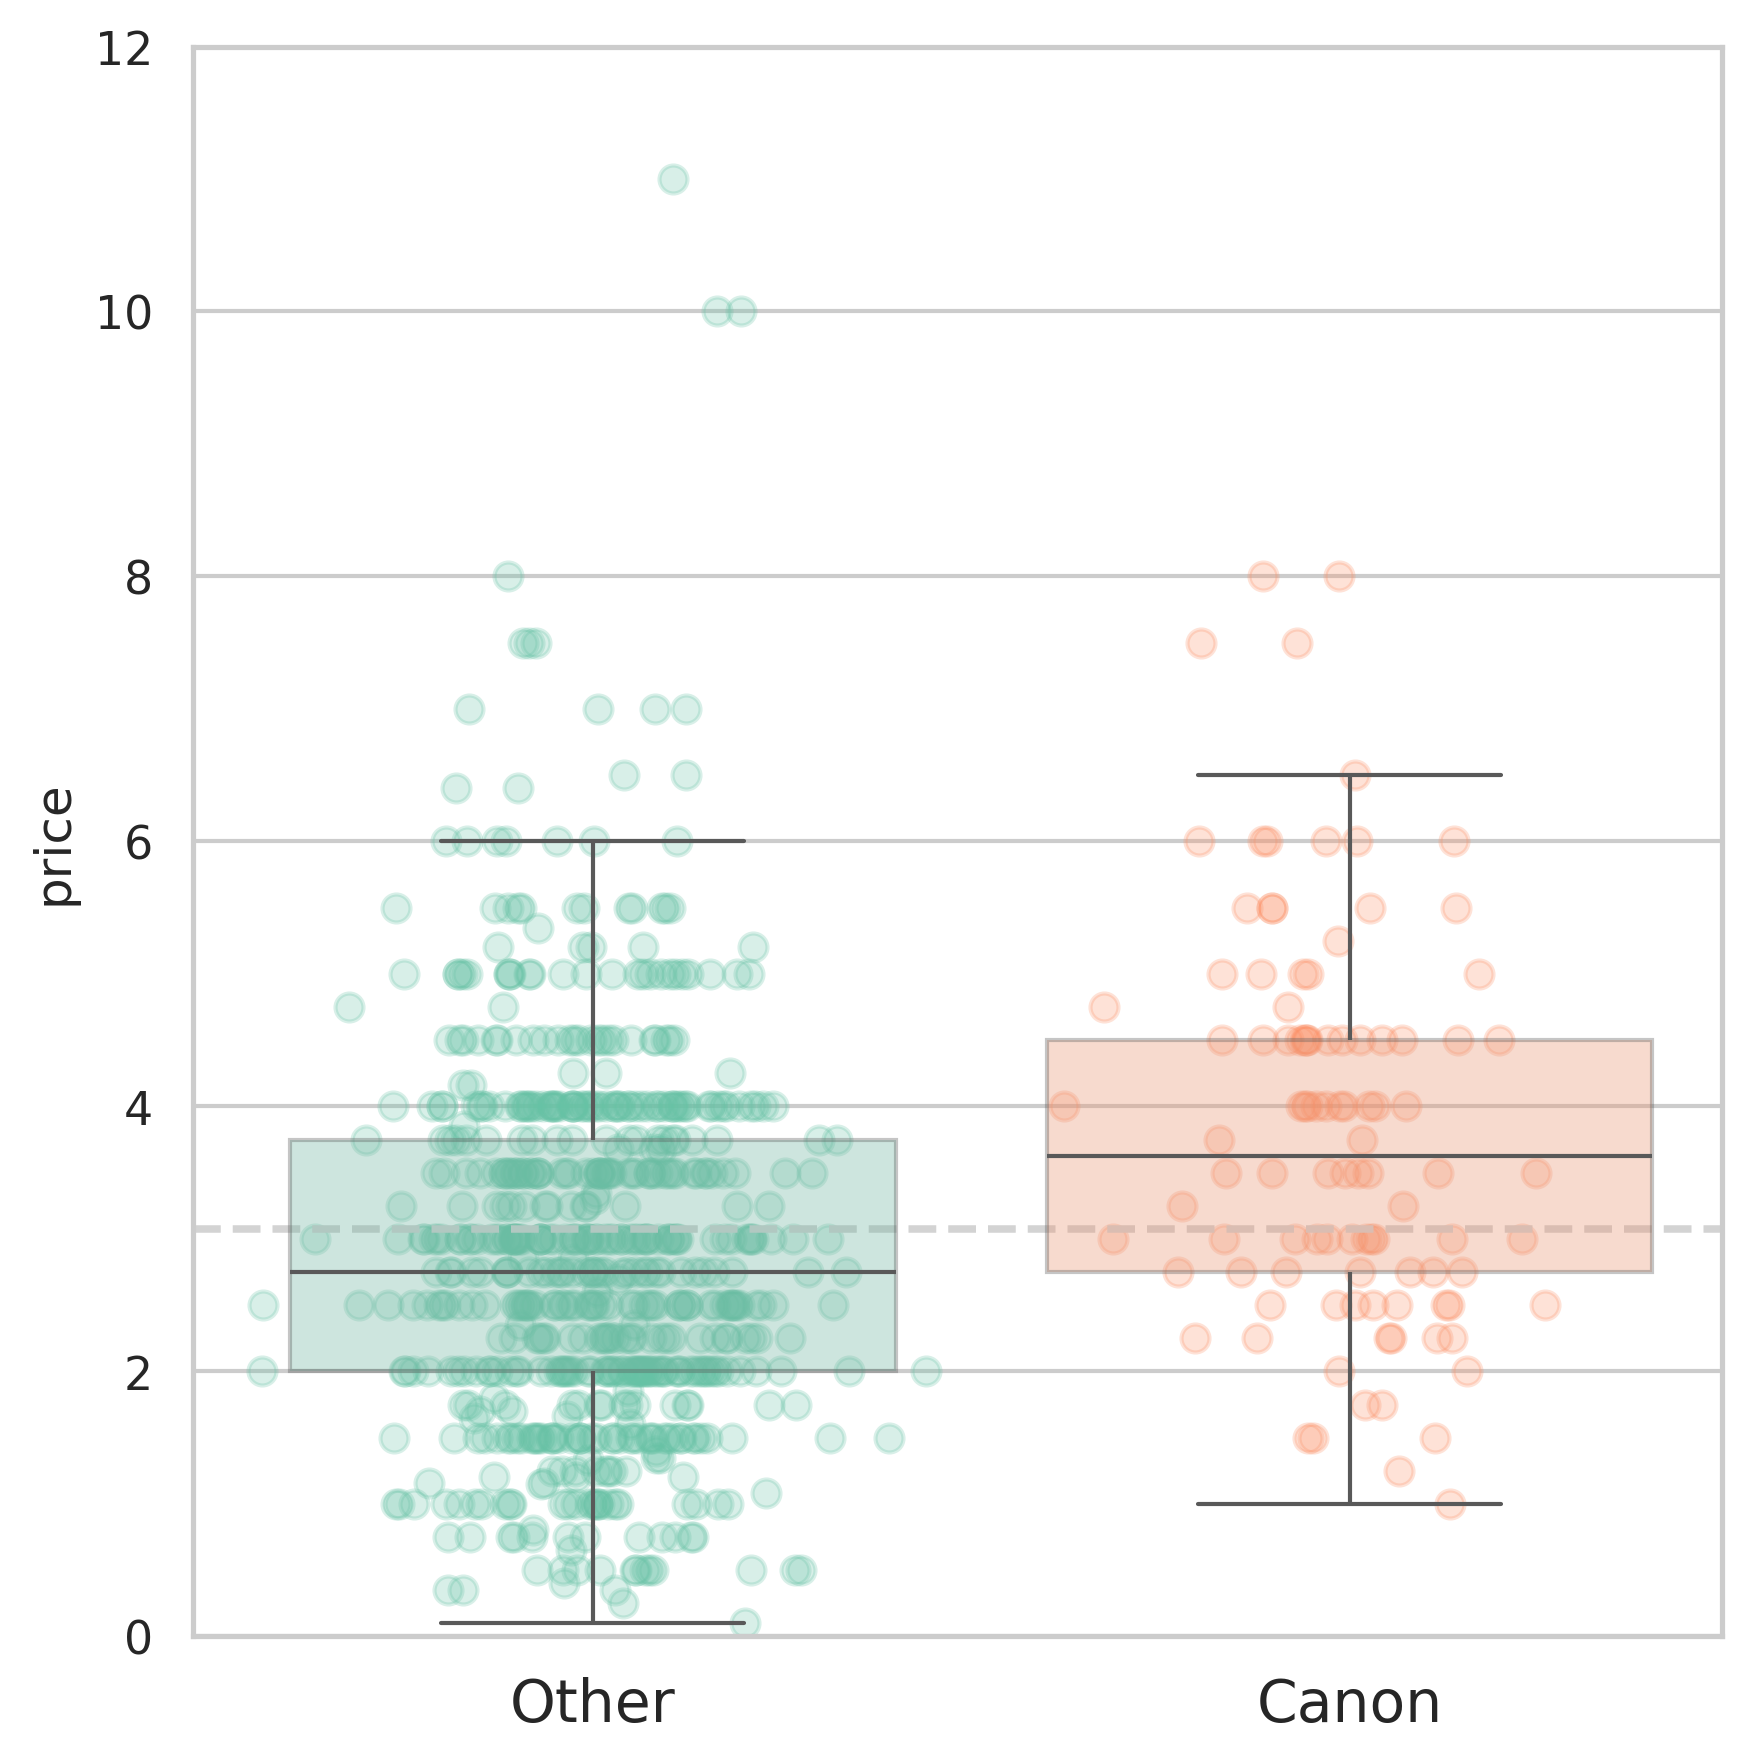

In [13]:
# Example usage
measure = 'price'
x = different_proxy_types_boxplots(df, 'category', measure, 6, 6)
x.savefig('figs/boxplots.pdf', bbox_inches='tight')

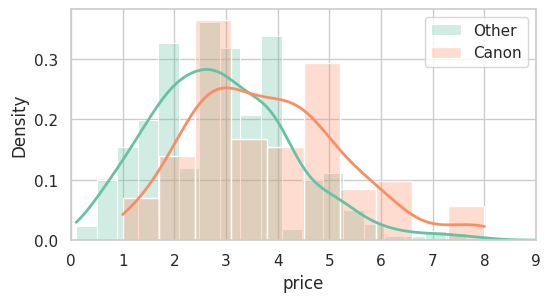

In [46]:
# make a distribution plot of the prices
# make some nice colors
unique_categories = df['category'].unique()

colors = sns.color_palette('Set2', n_colors=len(unique_categories))
plt.figure(figsize=(6, 3))
for i, group in enumerate([df[df['category'] == cat][measure] for cat in unique_cats]):
    sns.histplot(group, label=nice_labels[unique_cats[i]], kde=True, stat='density', color=colors[i], alpha=0.3, line_kws={'linewidth': 2})
plt.legend()
plt.xlabel('price')
plt.xlim(0, 9)
plt.savefig('figs/kde.pdf', bbox_inches='tight')

In [47]:
def plot_histograms_two_groups(df, scores_list, group_column='category', cutoff=None, logscale=None):
    plots_per_row = 3

    if len(scores_list) <= plots_per_row:
        fig, axes_list = plt.subplots(1, len(scores_list), figsize=(20, 4), dpi=300, sharey=True)
    else:
        rows = len(scores_list) // plots_per_row
        if len(scores_list) % plots_per_row != 0:
            rows += 1
        fig, axes_list = plt.subplots(rows, plots_per_row, figsize=(20, 4 * rows), dpi=300, sharey=True)
        
    fig.tight_layout(pad=3)

    canon = df.loc[df[group_column] == 1]
    noncanon = df.loc[df[group_column]== 0]
    print('len per group', len(canon), len(noncanon))

    labels = [x.replace('_', ' ').lower() for x in scores_list]

    for i, score in enumerate(scores_list):
        plt.tight_layout()

        sns.set(style="whitegrid", font_scale=2, font='serif')

        ax = axes_list.flat[i]

        sns.histplot(data=noncanon[score], ax=ax, color='#38a3a5')
        sns.histplot(data=canon[score], ax=ax, color='lightcoral')

        # Set labels
        ax.set_xlabel(labels[i])
        
        if i >= 1:
            ax.set_ylabel('')  # Set the y-axis label to an empty string
        
        if cutoff is not None:
            ax.set_ylim(0, cutoff)
        if logscale is not None:
            ax.set_xscale('log')

    plt.show()
    return fig

In [12]:
df.groupby('category')['auth_id2'].nunique()

category
Canon     20
Other    342
Name: auth_id2, dtype: int64

In [14]:
nationality_author_counts = df.groupby(["category", "nationality"])['auth_id2'].nunique().unstack(fill_value=0)
nationality_novel_counts = df.groupby(["category", "nationality"]).size().unstack(fill_value=0)
nationality_author_counts = nationality_author_counts[nationality_author_counts.sum(axis=0).sort_values(ascending=False).index]
nationality_novel_counts = nationality_novel_counts[nationality_novel_counts.sum(axis=0).sort_values(ascending=False).index]
nationality_author_percentages = nationality_author_counts.div(nationality_author_counts.sum(axis=1), axis=0)
nationality_novel_percentages = nationality_novel_counts.div(nationality_novel_counts.sum(axis=1), axis=0)

In [20]:
nationality_author_counts

nationality,dk,no,de
category,,,
Canon,14,6,0
Other,287,32,4


/tmp/ipykernel_430/2389552867.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  j, bottom[j] + val / 2,
/tmp/ipykernel_430/2389552867.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  j, bottom[j] + val / 2,


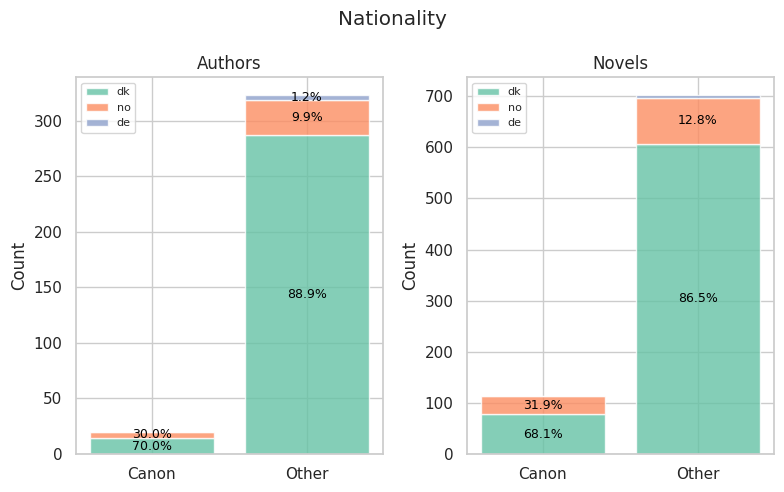

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharey=False)  # Six subplots in a 2x3 layout
sns.set(style="whitegrid")

# Define plotting function for modularity
def plot_stacked_bar(data_counts, data_percentages, title, ax, colors, legend_labels=None):
    bottom = np.zeros(len(categories))
    for i, col in enumerate(data_counts.columns):
        ax.bar(
            categories,
            data_counts[col],
            label=f"{col}" if not legend_labels else legend_labels[i],
            color=colors[i],
            bottom=bottom,
            alpha=0.8
        )

        for j, val in enumerate(data_counts[col]):
            if data_percentages[col].iloc[j] > 0.009:
                ax.text(
                    j, bottom[j] + val / 2,
                    f"{data_percentages[col].iloc[j] * 100:.1f}%",
                    ha="center",
                    va="center",
                    fontsize=9,
                    color="black"
                )
        bottom += data_counts[col]
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, ha="center")

def plot_stacked_bar_with_offset(data_counts, data_percentages, title, ax, colors, category_offset, legend_labels=None):
    bottom = np.zeros(len(categories))
    for i, col in enumerate(data_counts.columns):
        ax.bar(
            categories,
            data_counts[col],
            label=f"{col}" if not legend_labels else legend_labels[i],
            color=colors[i],
            bottom=bottom,
            alpha=0.8
        )
        for j, val in enumerate(data_counts[col]):
            # Apply offset only for the Canon category in Published Gender
            if category_offset and categories[j] == "Canon" and col in ["female", "neutral"]:
                offset = -0.1 if col == "female" else 0.1
                ha_align = "right" if col == "female" else "left"
            else:
                offset = 0
                ha_align = "center"
            # Add annotations
            if data_percentages[col].iloc[j] > 0.01:
                ax.text(
                    j + offset,
                    bottom[j] + val / 2,
                    f"{data_percentages[col].iloc[j] * 100:.1f}%",
                    ha=ha_align,
                    va="center",
                    fontsize=9,
                    color="black"
                )
        bottom += data_counts[col]
    ax.set_title()
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, ha="center")

# Define color palettes
colors_nationality = sns.color_palette("Set2", len(nationality_author_counts.columns))

# Plot for Nationality (Authors)
plot_stacked_bar(nationality_author_counts, nationality_author_percentages, "Authors", axes[0], colors_nationality)  #legend_labels=nationality_author_counts.columns)
#axes[0].set_ylabel('Authors')

# Plot for Nationality (Novels)
plot_stacked_bar(nationality_novel_counts, nationality_novel_percentages, "Novels", axes[1], colors_nationality) #, legend_labels=nationality_novel_counts.columns)
#axes[1].set_ylabel('Novels')

# Adjust layout, legends, and show
for ax in axes.flatten():
    ax.legend(loc="upper left", fontsize=8)
plt.suptitle('Nationality')
plt.tight_layout()

plt.savefig('figs/authors_novels_nationalities.pdf', bbox_inches='tight')
plt.show()

In [9]:
custom_cmap = sns.light_palette("#fc8d62", as_cmap=True)

/tmp/ipykernel_335/2890735250.py:66: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='white', edgecolor='white'))


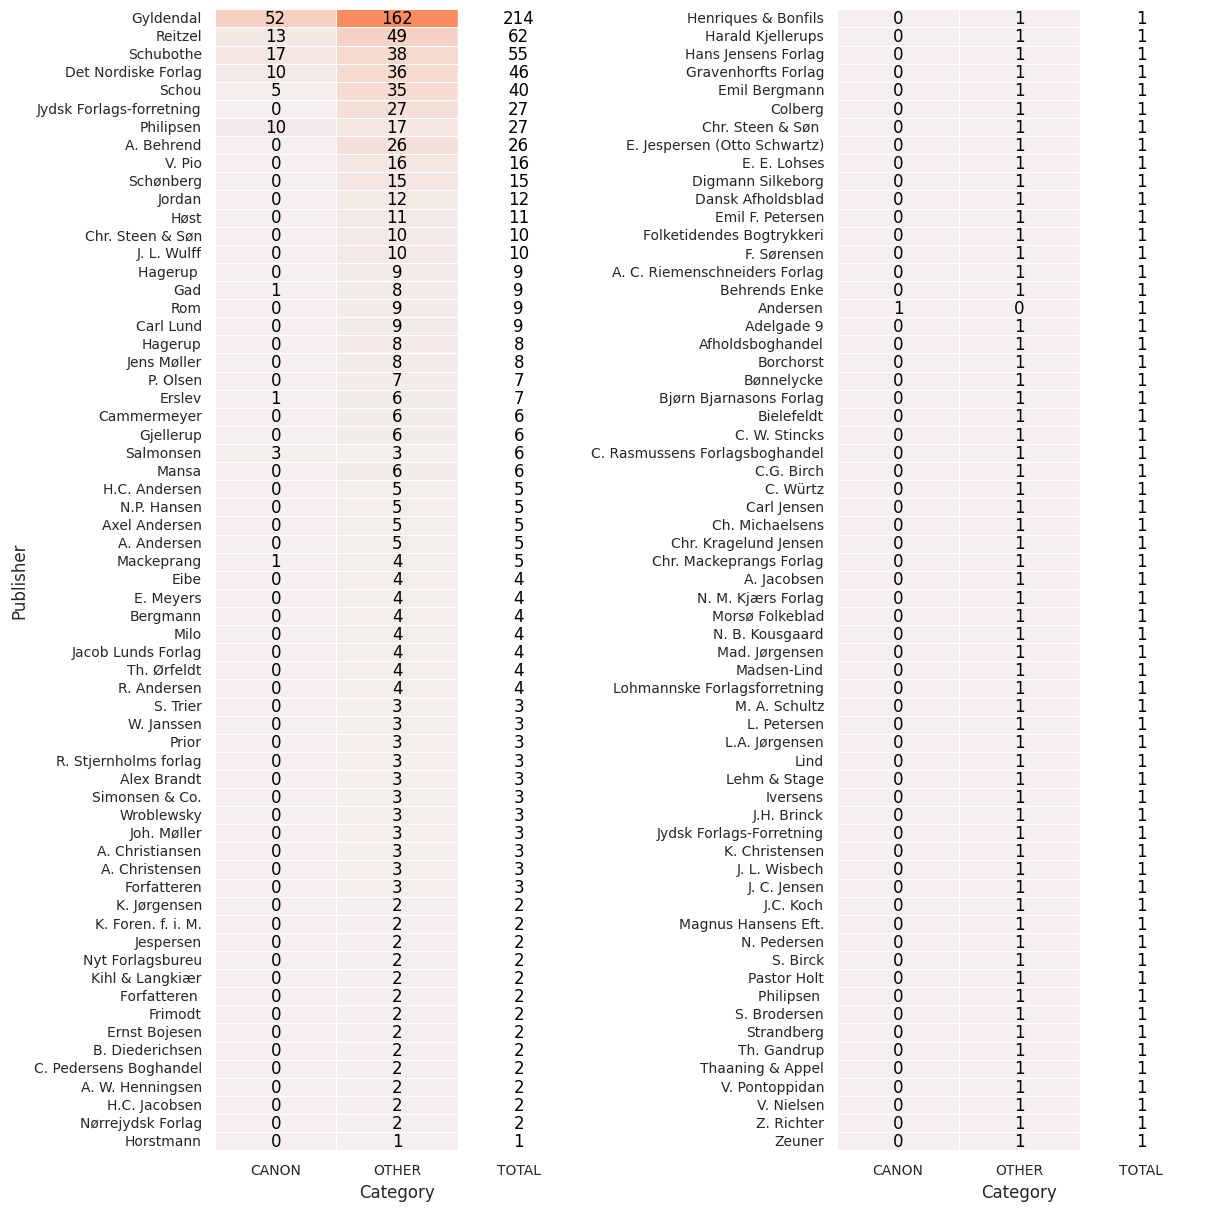

In [37]:
# Group by PUBLISHER and category, and count the number of books
heatmap_data = df.groupby(['PUBLISHER', 'category']).size().unstack(fill_value=0)

# Add a total column
heatmap_data['total'] = heatmap_data.sum(axis=1)

# Sort by the total column in descending order
heatmap_data = heatmap_data.sort_values(by='total', ascending=False)

# Split publishers into two halves
mid_point = len(heatmap_data) // 2
heatmap_left = heatmap_data.iloc[:mid_point]
heatmap_right = heatmap_data.iloc[mid_point:]

# Determine the common color range
vmin = heatmap_data[['CANON', 'O']].min().min()
vmax = heatmap_data[['CANON', 'O']].max().max()

# Plot the heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 12), constrained_layout=True)

# Left heatmap
sns.heatmap(
    heatmap_left,
    annot=True,
    fmt="d",
    cmap=custom_cmap,
    linewidths=0.5,
    cbar=False,
    ax=axes[0],
    vmin=vmin,
    vmax=vmax,
    yticklabels=heatmap_left.index
)
#axes[0].set_title("Left Half of Publishers")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Publisher")

# Right heatmap
sns.heatmap(
    heatmap_right,
    annot=True,
    fmt="d",
    cmap=custom_cmap,
    linewidths=0.5,
    cbar=False,
    ax=axes[1],
    vmin=vmin,
    vmax=vmax,
    yticklabels=heatmap_right.index
)
#axes[1].set_title("Right Half of Publishers")
axes[1].set_xlabel("Category")
axes[1].set_ylabel("")  # Remove the duplicate ylabel

# Customize annotations for both heatmaps
for ax, data in zip(axes, [heatmap_left, heatmap_right]):
    for text, (i, j) in zip(ax.texts, np.ndindex(data.shape)):
        text.set_color('black')
        value = float(text.get_text())
        if value.is_integer():
            text.set_text(f"{int(value)}")
        if data.columns[j] == 'total':  # Ensure count column text is black
            text.set_color('black')
            # Set white background for the cell
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='white', edgecolor='white'))

# Adjust tick labels
for ax in axes:
    ax.set_xticklabels(['CANON', 'OTHER', 'TOTAL'], ha='center', fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

#plt.suptitle("Number of Books by Publisher and Category", fontsize=14)
plt.savefig('figs/heatmap_publishers_absolute_nrs.pdf', bbox_inches='tight')

Text(0.5, 0.98, 'Percentage of Books by Publisher per Category')

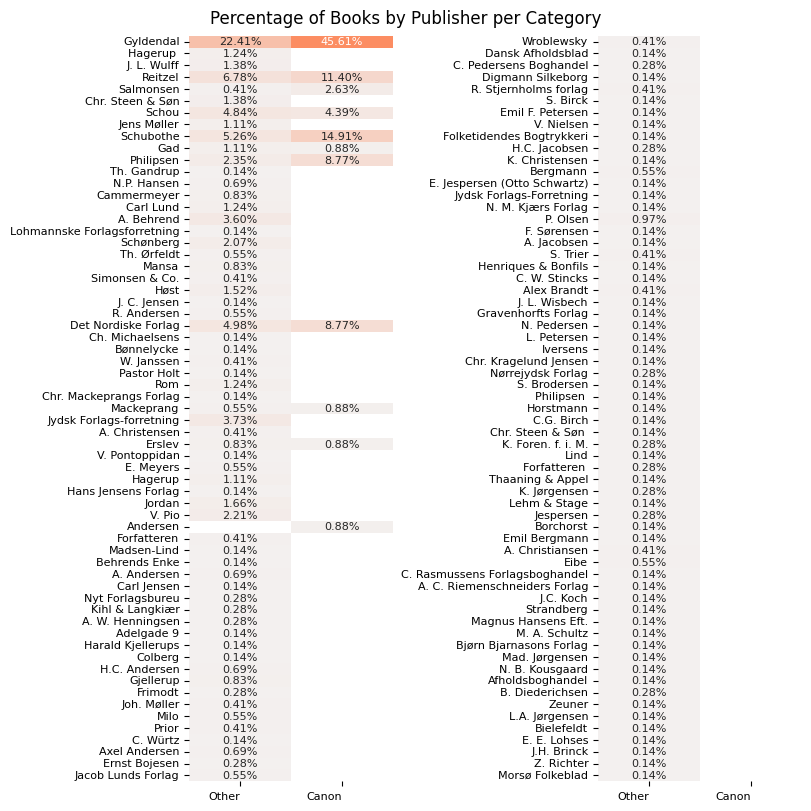

In [8]:
# get the unique values for the publishers
publishers = df['PUBLISHER'].unique()
publishers = publishers[pd.notnull(publishers)]  # Drop NaN values

# get the unique values for the categories
categories = df['category'].unique()

# create a matrix with the counts
matrix = np.zeros((len(publishers), len(categories)))

for i, publisher in enumerate(publishers):
    for j, category in enumerate(categories):
        matrix[i, j] = len(df[(df['PUBLISHER'] == publisher) & (df['category'] == category)])

# normalize the matrix to percentages
matrix_perc = matrix / (matrix.sum(axis=0, keepdims=True) + 1e-10)

# Split the publishers into two halves for two heatmaps
mid_point = len(publishers) // 2
publishers_left = publishers[:mid_point]
publishers_right = publishers[mid_point:]

# Corresponding matrices for each half
matrix_left = matrix_perc[:mid_point, :]
matrix_right = matrix_perc[mid_point:, :]

# Determine the common color range
vmin = 0
vmax = np.max(matrix_perc)

# Plot the heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 8), constrained_layout=True)

# Left heatmap
sns.heatmap(
    matrix_left, annot=True, fmt=".2%", xticklabels=[nice_labels[cat] for cat in categories],
    yticklabels=publishers_left, cbar=False, cmap=custom_cmap, ax=axes[0], annot_kws={"size": 8},
    vmin=vmin, vmax=vmax, mask=matrix_left==0
)

# Right heatmap
sns.heatmap(
    matrix_right, annot=True, fmt=".2%", xticklabels=[nice_labels[cat] for cat in categories],
    yticklabels=publishers_right, cbar=False, cmap=custom_cmap, ax=axes[1], annot_kws={"size": 8},
    vmin=vmin, vmax=vmax, mask=matrix_right==0
)

# Adjust labels
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

plt.suptitle("Percentage of Books by Publisher per Category", fontsize=12)
#plt.savefig('figs/heatmap.pdf', bbox_inches='tight')


In [63]:
# we want to get the entropy of each publisher distribution

# Calculate the entropy of each category's distribution of publishers
# make each a list
for cat in unique_categories:
    dist = df[df['category'] == cat]['PUBLISHER'].value_counts(normalize=True)
    print(f"Entropy of {nice_labels[cat]} distribution: {round(entropy(dist),3)}")

print('// and with sampling //')

# if we take a random sample of the smaller group (so all should have the size of the smallest group)
# we can calculate the entropy of the distribution of publishers
for cat in unique_categories:
    data = df[df['category'] == cat].sample(len(df[df['category'] == 'HISTORICAL']))
    dist = data['PUBLISHER'].value_counts(normalize=True)
    print(f"Entropy of {nice_labels[cat]} distribution: {round(entropy(dist),3)}")

Entropy of Other distribution: 3.657
Entropy of Canon distribution: 1.715
// and with sampling //
Entropy of Other distribution: 0.0
Entropy of Canon distribution: 0.0
